# Basic SHAP Interaction Value Example in XGBoost

This notebook shows how the SHAP interaction values for a very simple function are computed. We start with a simple linear function, and then add an interaction term to see how it changes the SHAP values and the SHAP interaction values.

In [1]:
import numpy as np
import xgboost

import shap

## Explain a linear function with no interactions

simulate some binary data and a linear outcome with an interaction term <br>
note we make the features in X perfectly independent of each other to make <br>
it easy to solve for the exact SHAP values

In [2]:
N = 2000
X = np.zeros((N, 5))
X[:1000, 0] = 1
X[:500, 1] = 1
X[1000:1500, 1] = 1
X[:250, 2] = 1
X[500:750, 2] = 1
X[1000:1250, 2] = 1
X[1500:1750, 2] = 1
X[:, 0:3] -= 0.5
y = 2 * X[:, 0] - 3 * X[:, 1]

ensure that variables are independent

In [3]:
np.cov(X.T)

array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.25012506, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.25012506, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

and mean centered

In [4]:
X.mean(0)

array([0., 0., 0., 0., 0.])

In [5]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)
print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 0.0
0:[f1<0] yes=1,no=2,missing=1,gain=4500,cover=2000
	1:[f0<0] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:leaf=0.5,cover=500
		4:leaf=2.5,cover=500
	2:[f0<0] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:leaf=-2.5,cover=500
		6:leaf=-0.5,cover=500



In [6]:
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

0.0

If we build a summary plot we see that only features 0 and 1 have any effect, and that their effects only have two possible magnitudes (1/-1 and 1.5/-1.5 correspondingly).

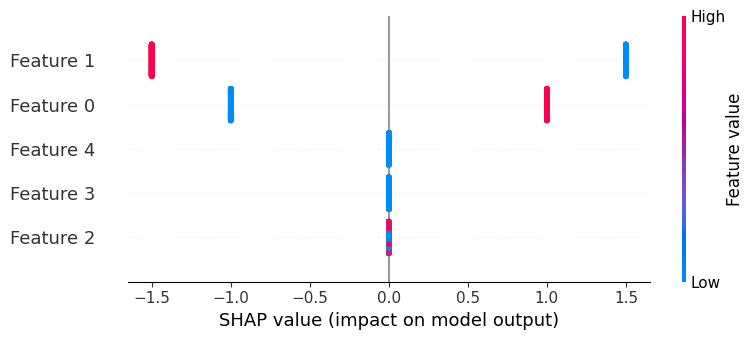

In [7]:
shap.summary_plot(shap_values, X)

train a linear model

In [8]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr.fit(X, y)
lr_pred = lr.predict(X)
lr.coef_.round(2)

array([ 2., -3., -0.,  0.,  0.])

Make sure the computed SHAP values match the true SHAP values
(we can compute the true SHAP values directly for any linear regression)

In [9]:
main_effect_shap_values = lr.coef_ * (X - X.mean(0))
np.linalg.norm(shap_values - main_effect_shap_values)

1.6542433490447965e-13

### SHAP Interaction Values

Note that when there are no interactions present the SHAP interaction values are just a diagonal matrix with the SHAP values on the diagonal.

In [10]:
shap_interaction_values = explainer.shap_interaction_values(Xd)
shap_interaction_values[0]

array([[ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -1.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]], dtype=float32)

ensure the SHAP interaction values sum to the marginal predictions

In [11]:
np.abs(shap_interaction_values.sum((1, 2)) + explainer.expected_value - pred).max()

0.0

ensure the main effects from the SHAP interaction values match those from a linear model

In [12]:
dinds = np.diag_indices(shap_interaction_values.shape[1])
total = 0
for i in range(N):
    for j in range(5):
        total += np.abs(
            shap_interaction_values[i, j, j] - main_effect_shap_values[i, j]
        )
total

1.0533118387982904e-11

## Explain a linear model with one interaction

simulate some binary data and a linear outcome with an interaction term <br>
note we make the features in X perfectly independent of each other to make <br>
it easy to solve for the exact SHAP values

In [13]:
N = 2000
X = np.zeros((N, 5))
X[:1000, 0] = 1

X[:500, 1] = 1
X[1000:1500, 1] = 1

X[:250, 2] = 1
X[500:750, 2] = 1
X[1000:1250, 2] = 1
X[1500:1750, 2] = 1

X[:125, 3] = 1
X[250:375, 3] = 1
X[500:625, 3] = 1
X[750:875, 3] = 1
X[1000:1125, 3] = 1
X[1250:1375, 3] = 1
X[1500:1625, 3] = 1
X[1750:1875, 3] = 1
X[
    :, :4
] -= 0.4999  # we can't exactly mean center the data or XGBoost has trouble finding the splits

# interaction of features is implemented as the multiplication of the features. Note that any other function of the
#  features would also work, but is harder to interpret (e.g. sin(x1*x2)).
y = 2 * X[:, 0] - 3 * X[:, 1] + 2 * X[:, 1] * X[:, 2]

In [14]:
X.mean(0)

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 0.e+00])

In [15]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 4, "base_score": 0, "lambda": 0}, Xd, 1)
print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 1.7365037830677591e-06
0:[f1<0.000100001693] yes=1,no=2,missing=1,gain=4499.3999,cover=2000
	1:[f0<0.000100001693] yes=3,no=4,missing=3,gain=1000.00024,cover=1000
		3:[f2<0.000100001693] yes=7,no=8,missing=7,gain=124.950005,cover=500
			7:leaf=0.99970001,cover=250
			8:leaf=-9.99800031e-05,cover=250
		4:[f2<0.000100001693] yes=9,no=10,missing=9,gain=124.950195,cover=500
			9:leaf=2.99970007,cover=250
			10:leaf=1.99989998,cover=250
	2:[f0<0.000100001693] yes=5,no=6,missing=5,gain=999.999756,cover=1000
		5:[f2<0.000100001693] yes=11,no=12,missing=11,gain=125.050049,cover=500
			11:leaf=-3.0000999,cover=250
			12:leaf=-1.99989998,cover=250
		6:[f2<0.000100001693] yes=13,no=14,missing=13,gain=125.050018,cover=500
			13:leaf=-1.00010002,cover=250
			14:leaf=0.000100019999,cover=250



make sure the SHAP values add up to marginal predictions

In [16]:
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

4.7683716e-07

If we build a summary plot we see that now only features 3 and 4 don't matter, and that feature 1 can have four possible effect sizes due to interactions.

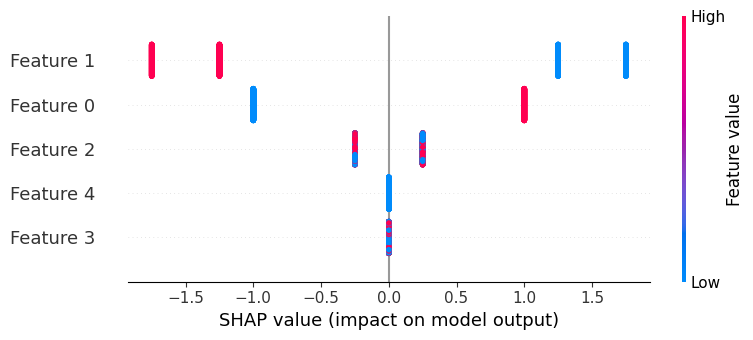

In [17]:
shap.summary_plot(shap_values, X)

train a linear model

In [18]:
lr = linear_model.LinearRegression()
lr.fit(X, y)
lr_pred = lr.predict(X)
lr.coef_.round(2)

array([ 2., -3.,  0., -0.,  0.])

Note that the SHAP values no longer match the main effects because they now include interaction effects

In [19]:
main_effect_shap_values = lr.coef_ * (X - X.mean(0))
np.linalg.norm(shap_values - main_effect_shap_values)

15.811387829626835

### SHAP interaction values

SHAP interaction contributions are displayed on the off-diagonal

In [20]:
shap_interaction_values = explainer.shap_interaction_values(Xd)
shap_interaction_values[0].round(2)

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.5 ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.25,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]], dtype=float32)

ensure the SHAP interaction values sum to the marginal predictions

In [21]:
np.abs(shap_interaction_values.sum((1, 2)) + explainer.expected_value - pred).max()

4.7683716e-07

ensure the main effects from the SHAP interaction values match those of a linear model. <br>
While the main effects no longer match the SHAP values when interactions are present, they do match <br>
the main effects on the diagonal of the SHAP interaction value matrix

In [22]:
dinds = np.diag_indices(shap_interaction_values.shape[1])
total = 0
for i in range(N):
    for j in range(5):
        total += np.abs(
            shap_interaction_values[i, j, j] - main_effect_shap_values[i, j]
        )
total

0.0005347490392160024

If we build a dependence plot for feature 0 we that it only takes two values and that these values are entirely dependent on the value of the feature and hence they lie on a straight line (the value of feature 0 entirely determines its effect because it has no interactions with other features).

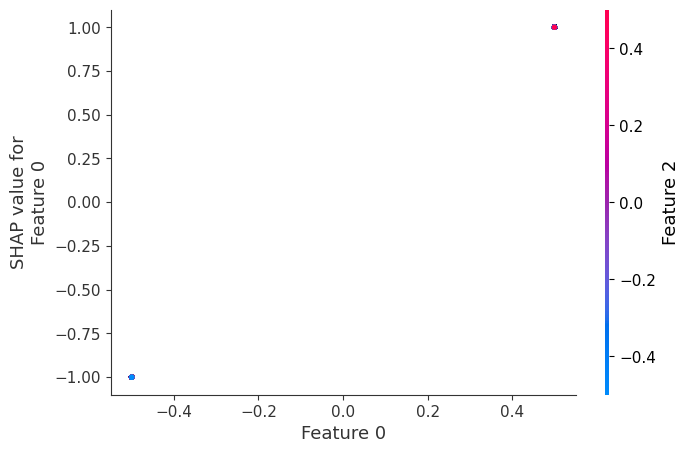

In [23]:
shap.dependence_plot(0, shap_values, X)

In contrast if we build a dependence plot for feature 2 we see that it takes 4 possible values and they are not entirely determined by the value of feature 2, instead they also depend on the value of feature 3. This vertical spread in a dependence plot represents the effects of non-linear interactions.

invalid value encountered in divide
invalid value encountered in divide


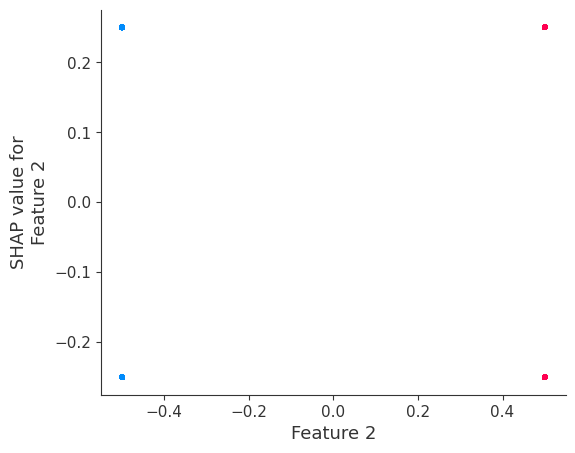

In [24]:
shap.dependence_plot(2, shap_values, X)